# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# BiLSTM-CRF Implementation

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.hidden_size = hidden_size
        self.num_tags = num_tags
        # BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(2*hidden_size, num_tags)
        # CRF layer
        self.crf = CRF(num_tags)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def neg_log_likelihood(self, x, tags):
        emissions = self(x)
        return -self.crf(emissions, tags)

    def forward_crf(self, x):
        emissions = self(x)
        out = self.crf.decode(emissions)
        out = torch.tensor(out)
        out = torch.nn.functional.one_hot(out, num_classes=self.num_tags)
        out = out.permute(1, 0, 2) # (len, 1, num_tags) to (1, len, num_tags)
        out = out.to(device=x.device)
        return out

# Example usage:
input_size = 300  # Example input size
hidden_size = 128  # Example hidden size
num_tags = 27  # Example number of tags
criteria = nn.CrossEntropyLoss()

# Example forward pass with CRF
model = BiLSTM_CRF(input_size, hidden_size, num_tags)
inputs = torch.randn(1, 19, input_size)  # Example input tensor
tags = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])  # Example tag tensor

neg_log_likelihood = model.neg_log_likelihood(inputs, tags)
decoded_tags = model.forward_crf(inputs)
print(inputs.shape, tags.shape)
print(decoded_tags.shape)
test_out = model(inputs)
print(test_out.shape)
loss = criteria(decoded_tags.float().view(-1, 27), tags.squeeze(0))
print(neg_log_likelihood)

torch.Size([1, 19, 300]) torch.Size([1, 19])
torch.Size([1, 19, 27])
torch.Size([1, 19, 27])
tensor(63.5823, grad_fn=<NegBackward0>)


# Training and Validation Code

In [82]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            # Compute loss
            # targets = targets.squeeze(0)
            # loss = criterion(outputs.float().view(-1, output_size), targets)
            loss = model.neg_log_likelihood(embedded_text, targets)
            targets = targets.squeeze(0)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model.forward_crf(embedded_text)
                # Compute loss
                # targets = targets.squeeze(0)
                # loss = criterion(outputs.float().view(-1, output_size), targets)
                loss = model.neg_log_likelihood(embedded_text, targets)
                targets = targets.squeeze(0)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [83]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            # Compute loss
            # targets = targets.squeeze(0)
            # loss = criterion(outputs.float().view(-1, output_size), targets)
            loss = model.neg_log_likelihood(embedded_text, targets)
            targets = targets.squeeze(0)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [84]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.squeeze(0).tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [63]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [106]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [124]:
bilstmcrf_word2vec_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_word2vec_model.parameters(), lr=0.001)

In [125]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=3)

Epoch 1/3


Training: Loss: 11.1095, Accuracy: 0.9092, F1: 0.4216
Validation: Loss: 8.3447, Accuracy: 0.9272, F1: 0.5272
Epoch 2/3
Training: Loss: 6.9613, Accuracy: 0.9364, F1: 0.5900
Validation: Loss: 7.2542, Accuracy: 0.9364, F1: 0.6107
Epoch 3/3
Training: Loss: 5.5361, Accuracy: 0.9484, F1: 0.6767
Validation: Loss: 7.1255, Accuracy: 0.9383, F1: 0.6393


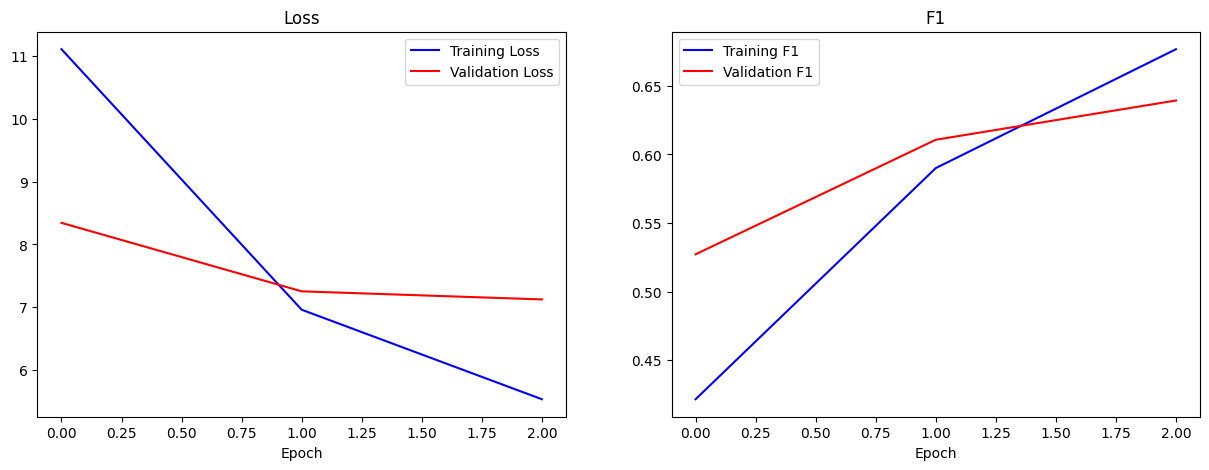

In [129]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [130]:
bilstmcrf_word2vec_model = bilstmcrf_word2vec_model.to('cpu')
torch.save(bilstmcrf_word2vec_model, "t1_model4_word2vec.pt")

Labelwise F1 Scores:
{0: 0.03809246380664448, 1: 0.06944444444444445, 2: 0.10830324909747292, 3: 0.0651851851851852, 4: 0.04950917626973965, 5: 0.05893832943013271, 6: 0.08910891089108912, 7: 0.136, 8: 0.14641288433382138, 9: 0.3045614035087719, 10: 0.1773248407643312, 11: 0.14906832298136646, 12: 0.0966685923358367, 13: 0.13636363636363638, 14: 0.09154669619785899, 15: 0.08654715676365764, 16: 0.29942100909842845, 17: 0.1, 18: 0.125, 19: 0.1142857142857143, 20: 0.08272058823529412, 21: 0.1904761904761905, 22: 0.125, 23: 0.14855072463768118, 24: 0.1818181818181818, 25: 0.05, 26: 0.08771929824561403}
Labelwise Accuracy Scores:
{0: 0.9809905316824472, 1: 0.45454545454545453, 2: 0.6104651162790697, 3: 0.41509433962264153, 4: 0.3741935483870968, 5: 0.5471014492753623, 6: 0.5538461538461539, 7: 0.6891891891891891, 8: 0.783289817232376, 9: 0.8410852713178295, 10: 0.7963386727688787, 11: 0.8089887640449438, 12: 0.7699386503067485, 13: 0.5172413793103449, 14: 0.7005649717514124, 15: 0.90843104

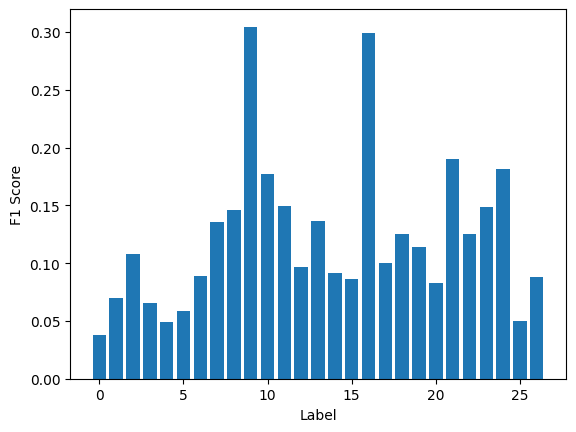

Bi-LSTM CRF with Word2Vec ==> Accuracy: 0.9371, F1: 0.6121


In [131]:
test_accuracy, test_f1 = test("t1_model4_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For GloVe Embeddings

In [132]:
input_size, hidden_size, output_size = 300, 128, 27
bilstmcrf_glove_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_glove_model.parameters(), lr=0.001)

In [137]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 6.9253, Accuracy: 0.9345, F1: 0.5791
Validation: Loss: 11.4528, Accuracy: 0.9060, F1: 0.4633
Epoch 2/10
Training: Loss: 6.2753, Accuracy: 0.9402, F1: 0.6125
Validation: Loss: 11.7206, Accuracy: 0.9060, F1: 0.4570
Epoch 3/10
Training: Loss: 5.6863, Accuracy: 0.9455, F1: 0.6428
Validation: Loss: 12.0611, Accuracy: 0.9042, F1: 0.4552
Epoch 4/10
Training: Loss: 5.2146, Accuracy: 0.9496, F1: 0.6637
Validation: Loss: 12.4535, Accuracy: 0.9026, F1: 0.4529
Epoch 5/10
Training: Loss: 4.9610, Accuracy: 0.9517, F1: 0.6783
Validation: Loss: 12.9311, Accuracy: 0.9018, F1: 0.4514
Epoch 6/10
Training: Loss: 4.6726, Accuracy: 0.9546, F1: 0.6951
Validation: Loss: 13.5349, Accuracy: 0.8995, F1: 0.4559
Epoch 7/10
Training: Loss: 4.3804, Accuracy: 0.9570, F1: 0.7133
Validation: Loss: 13.6539, Accuracy: 0.8991, F1: 0.4520
Epoch 8/10
Training: Loss: 4.2585, Accuracy: 0.9581, F1: 0.7216
Validation: Loss: 14.2505, Accuracy: 0.8992, F1: 0.4446
Epoch 9/10
Training: Loss: 4.0729, Accur

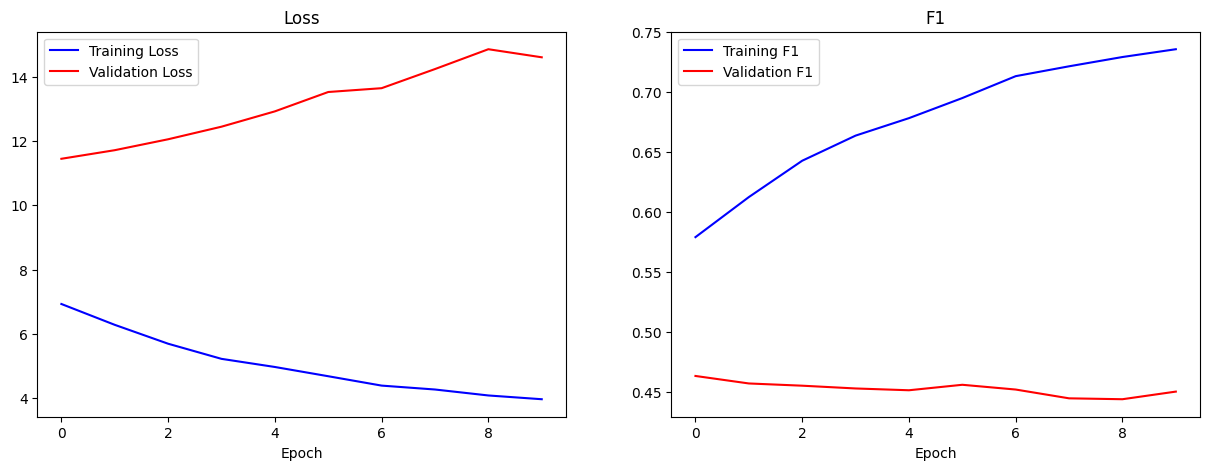

In [138]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [139]:
bilstmcrf_glove_model = bilstmcrf_glove_model.to('cpu')
torch.save(bilstmcrf_glove_model, "t1_model4_glove.pt")

Labelwise F1 Scores:
{0: 0.03626600578273441, 1: 0.0473559589581689, 2: 0.06337935568704799, 3: 0.018699532511687208, 4: 0.01934141265760803, 5: 0.020136054421768707, 6: 0.027500000000000004, 7: 0.07700831024930749, 8: 0.06119402985074627, 9: 0.06680161943319839, 10: 0.05427408412483039, 11: 0.05032679738562091, 12: 0.05886243386243386, 13: 0.05870841487279844, 14: 0.06279342723004695, 15: 0.04535647985550148, 16: 0.1287128712871287, 17: 0.07272727272727272, 18: 0.08888888888888889, 19: 0.07142857142857142, 20: 0.02782608695652174, 21: 0.06666666666666668, 22: 0.07272727272727272, 23: 0.12558869701726846, 24: 0.2222222222222222, 25: 0.08333333333333333, 26: 0.020583190394511147}
Labelwise Accuracy Scores:
{0: 0.9592134013109979, 1: 0.49586776859504134, 2: 0.7005813953488372, 3: 0.13836477987421383, 4: 0.25483870967741934, 5: 0.26811594202898553, 6: 0.28205128205128205, 7: 0.6261261261261262, 8: 0.7493472584856397, 9: 0.7674418604651163, 10: 0.6864988558352403, 11: 0.43258426966292135, 

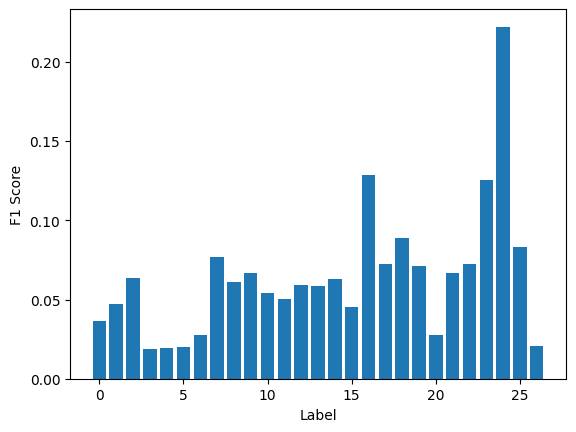

Bi-LSTM CRF with GloVe ==> Accuracy: 0.8958, F1: 0.4373


In [141]:
test_accuracy, test_f1 = test("t1_model4_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For FastText Embeddings

In [112]:
input_size, hidden_size, output_size = 300, 128, 27
bilstmcrf_fasttext_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_fasttext_model.parameters(), lr=0.001)

In [113]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        bilstmcrf_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 11.5861, Accuracy: 0.9069, F1: 0.4007
Validation: Loss: 7.7833, Accuracy: 0.9306, F1: 0.5124
Epoch 2/10
Training: Loss: 6.6262, Accuracy: 0.9394, F1: 0.5626
Validation: Loss: 6.7574, Accuracy: 0.9384, F1: 0.5878
Epoch 3/10
Training: Loss: 5.3267, Accuracy: 0.9502, F1: 0.6538
Validation: Loss: 6.4251, Accuracy: 0.9420, F1: 0.6280
Epoch 4/10
Training: Loss: 4.4308, Accuracy: 0.9581, F1: 0.7114
Validation: Loss: 6.4834, Accuracy: 0.9430, F1: 0.6323
Epoch 5/10
Training: Loss: 3.6617, Accuracy: 0.9656, F1: 0.7617
Validation: Loss: 6.9196, Accuracy: 0.9417, F1: 0.6378
Epoch 6/10
Training: Loss: 3.0287, Accuracy: 0.9715, F1: 0.8009
Validation: Loss: 7.3079, Accuracy: 0.9421, F1: 0.6418
Epoch 7/10
Training: Loss: 2.4845, Accuracy: 0.9769, F1: 0.8385
Validation: Loss: 7.6903, Accuracy: 0.9418, F1: 0.6372
Epoch 8/10
Training: Loss: 2.0868, Accuracy: 0.9806, F1: 0.8685
Validation: Loss: 7.8522, Accuracy: 0.9420, F1: 0.6484
Epoch 9/10
Training: Loss: 1.7806, Accuracy: 0.

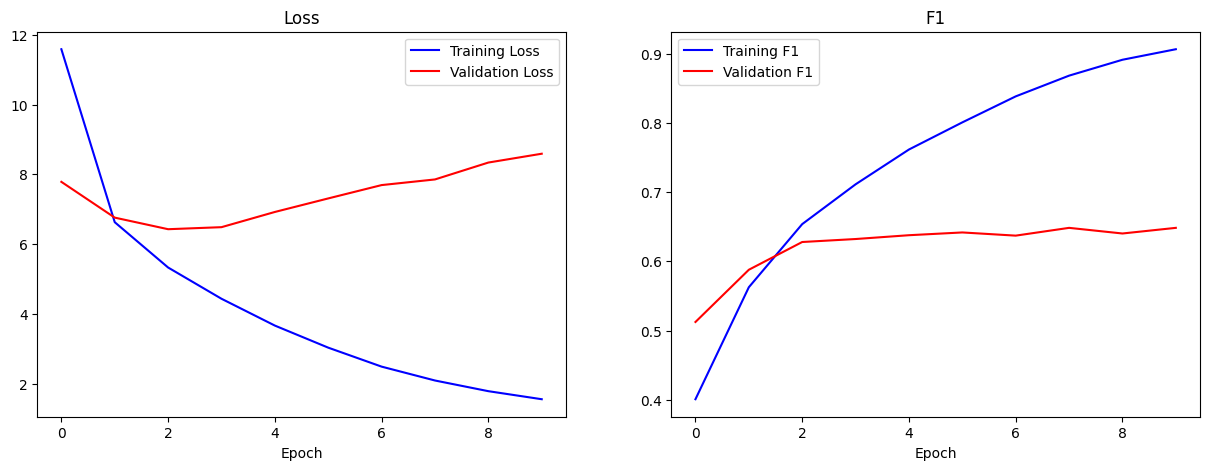

In [114]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [117]:
bilstmcrf_fasttext_model = bilstmcrf_fasttext_model.to('cpu')
torch.save(bilstmcrf_fasttext_model, "t1_model4_fasttext.pt")

Labelwise F1 Scores:
{0: 0.03965102396914317, 1: 0.08710217755443886, 2: 0.1294571882807177, 3: 0.054794520547945216, 4: 0.05747126436781609, 5: 0.06140350877192982, 6: 0.05131440588853838, 7: 0.1812807881773399, 8: 0.18868965517241382, 9: 0.18981670061099798, 10: 0.1574074074074074, 11: 0.15188583078491338, 12: 0.09354647720544701, 13: 0.0930232558139535, 14: 0.0854368932038835, 15: 0.07188944309705761, 16: 0.1875598086124402, 17: 0.12307692307692306, 18: 0.10416666666666667, 19: 0.10204081632653061, 20: 0.06960167714884696, 21: 0.06666666666666668, 22: 0.26666666666666666, 23: 0.19289340101522842, 24: 0.13636363636363635, 25: 0.27777777777777773, 26: 0.07650273224043716}
Labelwise Accuracy Scores:
{0: 0.9827021121631464, 1: 0.6446280991735537, 2: 0.8284883720930233, 3: 0.37735849056603776, 4: 0.4032258064516129, 5: 0.5833333333333334, 6: 0.6256410256410256, 7: 0.8288288288288288, 8: 0.8929503916449086, 9: 0.9031007751937985, 10: 0.8947368421052632, 11: 0.8370786516853933, 12: 0.72699

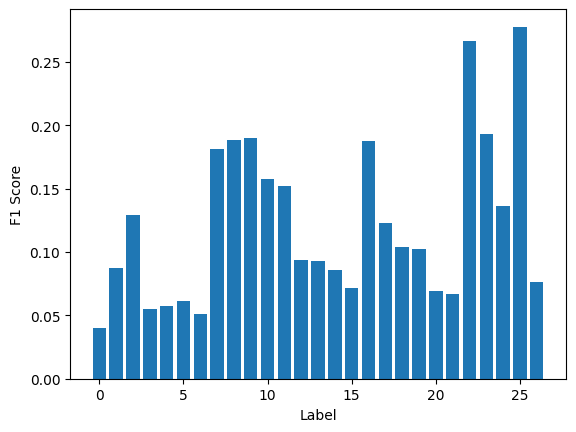

Bi-LSTM CRF with FastText ==> Accuracy: 0.9452, F1: 0.6408


In [118]:
test_accuracy, test_f1 = test("t1_model4_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))